#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/AIVLE_SCHOOL_5th/언어지능_딥러닝/2024.04.24_미니프로젝트6차_실습자료/'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [6]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [7]:
sales.head()

,Date,Store_ID,Qty,Product_ID
0,2014-01-01,1,0.0,3
1,2014-01-01,1,0.0,5
2,2014-01-01,1,0.0,7
3,2014-01-01,1,0.0,8
4,2014-01-01,1,0.0,10


In [8]:
orders.head()

,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875
3,2014-01-02,2,2122
4,2014-01-02,3,3350


In [9]:
products.loc[products['Product_ID'] == 3]

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
13,3,DB001,Beverage,Drink,2,8


In [10]:
stores.head()

,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4
3,4,Saint Paul,\tMinnesota,4
4,5,Oklahoma City,Oklahoma,4


In [11]:
oil_price.head()

,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66
3,2014-01-06,93.12
4,2014-01-07,93.31


In [12]:
orders.shape

(57558, 3)

In [13]:
stores.shape

(54, 4)

In [14]:
# stores + orders
df_orders = pd.merge(orders, stores, on='Store_ID', how='left')
df_orders.reset_index(drop=True, inplace=True)
df_orders.head()

,Date,Store_ID,CustomerCount,City,State,Store_Type
0,2014-01-01,25,840,Olympia,Washington,4
1,2014-01-01,36,487,Wilmington,\tNorth Carolina,5
2,2014-01-02,1,1875,Saint Paul,\tMinnesota,4
3,2014-01-02,2,2122,Saint Paul,\tMinnesota,4
4,2014-01-02,3,3350,Saint Paul,\tMinnesota,4


In [15]:
df_sales = pd.merge(sales, products, on='Product_ID', how='left')
# print(df_sales)
df_sales = pd.merge(df_sales, oil_price, on='Date', how='left')
df_sales.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,WTI_Price
0,2014-01-01,1,0.0,3,DB001,Beverage,Drink,2,8,NaN
1,2014-01-01,1,0.0,5,FB001,BAKERY,Food,2,6,NaN
2,2014-01-01,1,0.0,7,HC001,Cleaning,Household Goods,2,15,NaN
3,2014-01-01,1,0.0,8,FM001,Yogurt,Food,2,4,NaN
4,2014-01-01,1,0.0,10,GE001,EGGS,Grocery,2,5,NaN


In [16]:
df = pd.merge(df_sales, df_orders, on=['Date', 'Store_ID'], how='left')
df.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,WTI_Price,CustomerCount,City,State,Store_Type
0,2014-01-01,1,0.0,3,DB001,Beverage,Drink,2,8,NaN,NaN,NaN,NaN,NaN
1,2014-01-01,1,0.0,5,FB001,BAKERY,Food,2,6,NaN,NaN,NaN,NaN,NaN
2,2014-01-01,1,0.0,7,HC001,Cleaning,Household Goods,2,15,NaN,NaN,NaN,NaN,NaN
3,2014-01-01,1,0.0,8,FM001,Yogurt,Food,2,4,NaN,NaN,NaN,NaN,NaN
4,2014-01-01,1,0.0,10,GE001,EGGS,Grocery,2,5,NaN,NaN,NaN,NaN,NaN


In [17]:
df.shape

(934275, 14)

In [18]:
df.loc[(df['Store_ID'] == 44) & (df['Product_ID'] == 3)]

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,WTI_Price,CustomerCount,City,State,Store_Type
645,2014-01-01,44,0.0,3,DB001,Beverage,Drink,2,8,NaN,NaN,NaN,NaN,NaN
1456,2014-01-02,44,9853.0,3,DB001,Beverage,Drink,2,8,95.14,4422.0,Saint Paul,\tMinnesota,1.0
2267,2014-01-03,44,8647.0,3,DB001,Beverage,Drink,2,8,93.66,4167.0,Saint Paul,\tMinnesota,1.0
3078,2014-01-04,44,15153.0,3,DB001,Beverage,Drink,2,8,NaN,5341.0,Saint Paul,\tMinnesota,1.0
3889,2014-01-05,44,15606.0,3,DB001,Beverage,Drink,2,8,NaN,5123.0,Saint Paul,\tMinnesota,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930865,2017-02-24,44,10208.0,3,DB001,Beverage,Drink,2,8,53.99,4549.0,Saint Paul,\tMinnesota,1.0
931676,2017-02-25,44,12361.0,3,DB001,Beverage,Drink,2,8,NaN,4619.0,Saint Paul,\tMinnesota,1.0
932487,2017-02-26,44,10108.0,3,DB001,Beverage,Drink,2,8,NaN,3877.0,Saint Paul,\tMinnesota,1.0
933298,2017-02-27,44,10006.0,3,DB001,Beverage,Drink,2,8,54.04,3961.0,Saint Paul,\tMinnesota,1.0


In [19]:
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.day_name()
df.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,WTI_Price,CustomerCount,City,State,Store_Type,Month,Weekday
0,2014-01-01,1,0.0,3,DB001,Beverage,Drink,2,8,NaN,NaN,NaN,NaN,NaN,1,Wednesday
1,2014-01-01,1,0.0,5,FB001,BAKERY,Food,2,6,NaN,NaN,NaN,NaN,NaN,1,Wednesday
2,2014-01-01,1,0.0,7,HC001,Cleaning,Household Goods,2,15,NaN,NaN,NaN,NaN,NaN,1,Wednesday
3,2014-01-01,1,0.0,8,FM001,Yogurt,Food,2,4,NaN,NaN,NaN,NaN,NaN,1,Wednesday
4,2014-01-01,1,0.0,10,GE001,EGGS,Grocery,2,5,NaN,NaN,NaN,NaN,NaN,1,Wednesday


In [20]:
# def get_season(month):
#     if month in [3, 4, 5]:
#         return 'Spring'
#     elif month in [6, 7, 8]:
#         return 'Summer'
#     elif month in [9, 10, 11]:
#         return 'Fall'
#     else:
#         return 'Winter'

# # apply 함수를 사용하여 계절(season) 컬럼 추가
# df['season'] = df['Month'].apply(get_season)
# df.head()

In [21]:
df = pd.get_dummies(df, columns=['Month', 'Weekday'], drop_first=True, dtype=int)
df.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,WTI_Price,...,Month_9,Month_10,Month_11,Month_12,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,2014-01-01,1,0.0,3,DB001,Beverage,Drink,2,8,NaN,...,0,0,0,0,0,0,0,0,0,1
1,2014-01-01,1,0.0,5,FB001,BAKERY,Food,2,6,NaN,...,0,0,0,0,0,0,0,0,0,1
2,2014-01-01,1,0.0,7,HC001,Cleaning,Household Goods,2,15,NaN,...,0,0,0,0,0,0,0,0,0,1
3,2014-01-01,1,0.0,8,FM001,Yogurt,Food,2,4,NaN,...,0,0,0,0,0,0,0,0,0,1
4,2014-01-01,1,0.0,10,GE001,EGGS,Grocery,2,5,NaN,...,0,0,0,0,0,0,0,0,0,1


In [22]:
df.columns

Index(['Date', 'Store_ID', 'Qty', 'Product_ID', 'Product_Code', 'SubCategory',
       'Category', 'LeadTime', 'Price', 'WTI_Price', 'CustomerCount', 'City',
       'State', 'Store_Type', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday',
       'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday'],
      dtype='object')

In [23]:
df.tail()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,WTI_Price,...,Month_9,Month_10,Month_11,Month_12,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
934270,2017-02-28,54,24.000,38,DA001,Wine,Drink,2,12,54.0,...,0,0,0,0,0,0,0,0,1,0
934271,2017-02-28,54,49.222,24,GM001,Meats,Grocery,3,17,54.0,...,0,0,0,0,0,0,0,0,1,0
934272,2017-02-28,54,12.000,27,HH001,Home Appliances,Household Goods,2,150,54.0,...,0,0,0,0,0,0,0,0,1,0
934273,2017-02-28,54,59.000,29,FP001,Prepared,Food,2,18,54.0,...,0,0,0,0,0,0,0,0,1,0
934274,2017-02-28,54,4.000,32,GS001,Seafood,Grocery,3,34,54.0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
# 아마존 데이터 추가
amazon = pd.read_csv(path + 'train/AMZN.csv')
amazon['Date'] = pd.to_datetime(amazon['Date'])
amazon = amazon.loc[amazon['Date'].between('2014-01-01', '2017-02-28')]

In [25]:
df.to_csv(path + 'data.csv')

## **(1) 상품 : 3 - Beverage**

In [ ]:
df = df.loc[(df['Store_ID'] == 44) & (df['Product_ID'] == 3)]
df.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,WTI_Price,...,Month_9,Month_10,Month_11,Month_12,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
645,2014-01-01,44,0.0,3,DB001,Beverage,Drink,2,8,NaN,...,0,0,0,0,0,0,0,0,0,1
1456,2014-01-02,44,9853.0,3,DB001,Beverage,Drink,2,8,95.14,...,0,0,0,0,0,0,0,1,0,0
2267,2014-01-03,44,8647.0,3,DB001,Beverage,Drink,2,8,93.66,...,0,0,0,0,0,0,0,0,0,0
3078,2014-01-04,44,15153.0,3,DB001,Beverage,Drink,2,8,NaN,...,0,0,0,0,0,1,0,0,0,0
3889,2014-01-05,44,15606.0,3,DB001,Beverage,Drink,2,8,NaN,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
df = pd.merge(df, amazon, on='Date', how='left')
df.isna().sum()

Date                   0
Store_ID               0
Qty                    0
Product_ID             0
Product_Code           0
SubCategory            0
Category               0
LeadTime               0
Price                  0
WTI_Price            357
CustomerCount          6
City                   6
State                  6
Store_Type             6
Month_2                0
Month_3                0
Month_4                0
Month_5                0
Month_6                0
Month_7                0
Month_8                0
Month_9                0
Month_10               0
Month_11               0
Month_12               0
Weekday_Monday         0
Weekday_Saturday       0
Weekday_Sunday         0
Weekday_Thursday       0
Weekday_Tuesday        0
Weekday_Wednesday      0
Open                 357
High                 357
Low                  357
Close                357
Adj Close            357
Volume               357
dtype: int64

In [ ]:
drop_cols = ['Product_ID', 'Store_ID', 'Product_Code', 'SubCategory', 'Category', 'City', 'State', 'Store_Type']
beverage = df.drop(columns=drop_cols, axis=1)
beverage.reset_index(drop=True, inplace=True)
beverage.head()

,Date,Qty,LeadTime,Price,WTI_Price,CustomerCount,Month_2,Month_3,Month_4,Month_5,...,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Open,High,Low,Close,Adj Close,Volume
0,2014-01-01,0.0,2,8,NaN,NaN,0,0,0,0,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-02,9853.0,2,8,95.14,4422.0,0,0,0,0,...,0,1,0,0,19.940001,19.9680,19.701000,19.898500,19.898500,42756000.0
2,2014-01-03,8647.0,2,8,93.66,4167.0,0,0,0,0,...,0,0,0,0,19.914499,20.1355,19.811001,19.822001,19.822001,44204000.0
3,2014-01-04,15153.0,2,8,NaN,5341.0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-05,15606.0,2,8,NaN,5123.0,0,0,0,0,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
beverage.shape

(1152, 29)

In [ ]:
beverage.loc[beverage['WTI_Price'].isna()]

,Date,Qty,LeadTime,Price,WTI_Price,CustomerCount,Month_2,Month_3,Month_4,Month_5,...,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Open,High,Low,Close,Adj Close,Volume
0,2014-01-01,0.0,2,8,NaN,NaN,0,0,0,0,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-04,15153.0,2,8,NaN,5341.0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-05,15606.0,2,8,NaN,5123.0,0,0,0,0,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
10,2014-01-11,12599.0,2,8,NaN,5053.0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
11,2014-01-12,13383.0,2,8,NaN,4852.0,0,0,0,0,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,2017-02-18,16331.0,2,8,NaN,5418.0,1,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1142,2017-02-19,12023.0,2,8,NaN,3986.0,1,0,0,0,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1143,2017-02-20,6004.0,2,8,NaN,3018.0,1,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1148,2017-02-25,12361.0,2,8,NaN,4619.0,1,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
beverage.isna().sum()

Date                   0
Qty                    0
LeadTime               0
Price                  0
WTI_Price            357
CustomerCount          6
Month_2                0
Month_3                0
Month_4                0
Month_5                0
Month_6                0
Month_7                0
Month_8                0
Month_9                0
Month_10               0
Month_11               0
Month_12               0
Weekday_Monday         0
Weekday_Saturday       0
Weekday_Sunday         0
Weekday_Thursday       0
Weekday_Tuesday        0
Weekday_Wednesday      0
Open                 357
High                 357
Low                  357
Close                357
Adj Close            357
Volume               357
dtype: int64

In [ ]:
# Qty shift
beverage['Qty'] = beverage['Qty'].shift(-2)
beverage.head()

,Date,Qty,LeadTime,Price,WTI_Price,CustomerCount,Month_2,Month_3,Month_4,Month_5,...,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Open,High,Low,Close,Adj Close,Volume
0,2014-01-01,8647.0,2,8,NaN,NaN,0,0,0,0,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-02,15153.0,2,8,95.14,4422.0,0,0,0,0,...,0,1,0,0,19.940001,19.9680,19.701000,19.898500,19.898500,42756000.0
2,2014-01-03,15606.0,2,8,93.66,4167.0,0,0,0,0,...,0,0,0,0,19.914499,20.1355,19.811001,19.822001,19.822001,44204000.0
3,2014-01-04,7900.0,2,8,NaN,5341.0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-05,7188.0,2,8,NaN,5123.0,0,0,0,0,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
beverage.tail()

,Date,Qty,LeadTime,Price,WTI_Price,CustomerCount,Month_2,Month_3,Month_4,Month_5,...,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Open,High,Low,Close,Adj Close,Volume
1147,2017-02-24,10108.0,2,8,53.99,4549.0,1,0,0,0,...,0,0,0,0,42.234501,42.290501,41.887501,42.262001,42.262001,73760000.0
1148,2017-02-25,10006.0,2,8,NaN,4619.0,1,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1149,2017-02-26,14374.0,2,8,NaN,3877.0,1,0,0,0,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1150,2017-02-27,NaN,2,8,54.04,3961.0,1,0,0,0,...,0,0,0,0,42.118999,42.625000,41.983501,42.431999,42.431999,54272000.0
1151,2017-02-28,NaN,2,8,54.00,4589.0,1,0,0,0,...,0,0,1,0,42.572498,42.704498,42.102501,42.251999,42.251999,55874000.0


In [ ]:
beverage['Qty'] = beverage['Qty'].fillna(method='ffill')
beverage.tail()

,Date,Qty,LeadTime,Price,WTI_Price,CustomerCount,Month_2,Month_3,Month_4,Month_5,...,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Open,High,Low,Close,Adj Close,Volume
1147,2017-02-24,10108.0,2,8,53.99,4549.0,1,0,0,0,...,0,0,0,0,42.234501,42.290501,41.887501,42.262001,42.262001,73760000.0
1148,2017-02-25,10006.0,2,8,NaN,4619.0,1,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1149,2017-02-26,14374.0,2,8,NaN,3877.0,1,0,0,0,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1150,2017-02-27,14374.0,2,8,54.04,3961.0,1,0,0,0,...,0,0,0,0,42.118999,42.625000,41.983501,42.431999,42.431999,54272000.0
1151,2017-02-28,14374.0,2,8,54.00,4589.0,1,0,0,0,...,0,0,1,0,42.572498,42.704498,42.102501,42.251999,42.251999,55874000.0


In [ ]:
# Open                 357
# High                 357
# Low                  357
# Close                357
# Adj Close            357
# Volume               357

beverage['WTI_Price'] = beverage['WTI_Price'].fillna(method='ffill')
beverage['WTI_Price'] = beverage['WTI_Price'].fillna(method='bfill')

beverage['Open'] = beverage['Open'].fillna(method='ffill')
beverage['Open'] = beverage['Open'].fillna(method='bfill')

beverage['High'] = beverage['High'].fillna(method='ffill')
beverage['High'] = beverage['High'].fillna(method='bfill')

beverage['Low'] = beverage['Low'].fillna(method='ffill')
beverage['Low'] = beverage['Low'].fillna(method='bfill')

beverage['Close'] = beverage['Close'].fillna(method='ffill')
beverage['Close'] = beverage['Close'].fillna(method='bfill')

beverage['Adj Close'] = beverage['Adj Close'].fillna(method='ffill')
beverage['Adj Close'] = beverage['Adj Close'].fillna(method='bfill')

beverage['Volume'] = beverage['Volume'].fillna(method='ffill')
beverage['Volume'] = beverage['Volume'].fillna(method='bfill')

beverage.isna().sum()

Date                 0
Qty                  0
LeadTime             0
Price                0
WTI_Price            0
CustomerCount        6
Month_2              0
Month_3              0
Month_4              0
Month_5              0
Month_6              0
Month_7              0
Month_8              0
Month_9              0
Month_10             0
Month_11             0
Month_12             0
Weekday_Monday       0
Weekday_Saturday     0
Weekday_Sunday       0
Weekday_Thursday     0
Weekday_Tuesday      0
Weekday_Wednesday    0
Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
dtype: int64

In [ ]:
beverage.sort_values(by='Date', inplace=True)
beverage.drop(columns=['LeadTime', 'Date'], inplace=True)
# beverage.set_index(keys='Date', drop=True, inplace=True)
beverage.head()

,Qty,Price,WTI_Price,CustomerCount,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Open,High,Low,Close,Adj Close,Volume
0,8647.0,8,95.14,NaN,0,0,0,0,0,0,...,0,0,0,1,19.940001,19.9680,19.701000,19.898500,19.898500,42756000.0
1,15153.0,8,95.14,4422.0,0,0,0,0,0,0,...,0,1,0,0,19.940001,19.9680,19.701000,19.898500,19.898500,42756000.0
2,15606.0,8,93.66,4167.0,0,0,0,0,0,0,...,0,0,0,0,19.914499,20.1355,19.811001,19.822001,19.822001,44204000.0
3,7900.0,8,93.66,5341.0,0,0,0,0,0,0,...,0,0,0,0,19.914499,20.1355,19.811001,19.822001,19.822001,44204000.0
4,7188.0,8,93.66,5123.0,0,0,0,0,0,0,...,1,0,0,0,19.914499,20.1355,19.811001,19.822001,19.822001,44204000.0


In [ ]:
beverage['CustomerCount'] = beverage['CustomerCount'].fillna(0)
beverage.isna().sum()

Qty                  0
Price                0
WTI_Price            0
CustomerCount        0
Month_2              0
Month_3              0
Month_4              0
Month_5              0
Month_6              0
Month_7              0
Month_8              0
Month_9              0
Month_10             0
Month_11             0
Month_12             0
Weekday_Monday       0
Weekday_Saturday     0
Weekday_Sunday       0
Weekday_Thursday     0
Weekday_Tuesday      0
Weekday_Wednesday    0
Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
dtype: int64

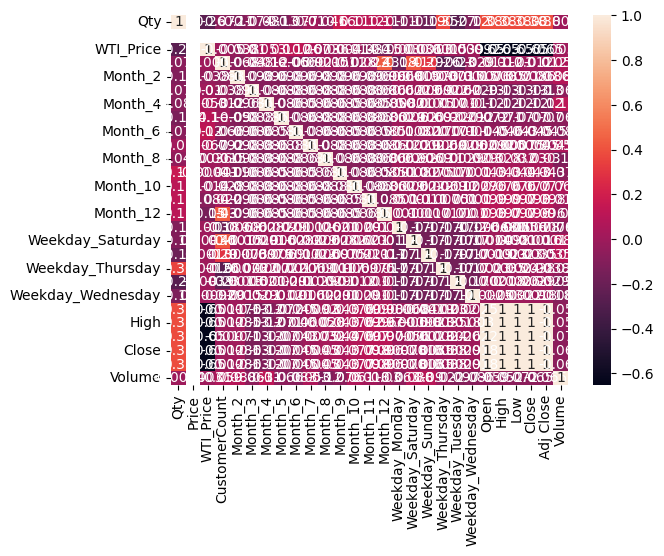

In [ ]:
sns.heatmap(beverage.corr(), annot=True)
plt.show()

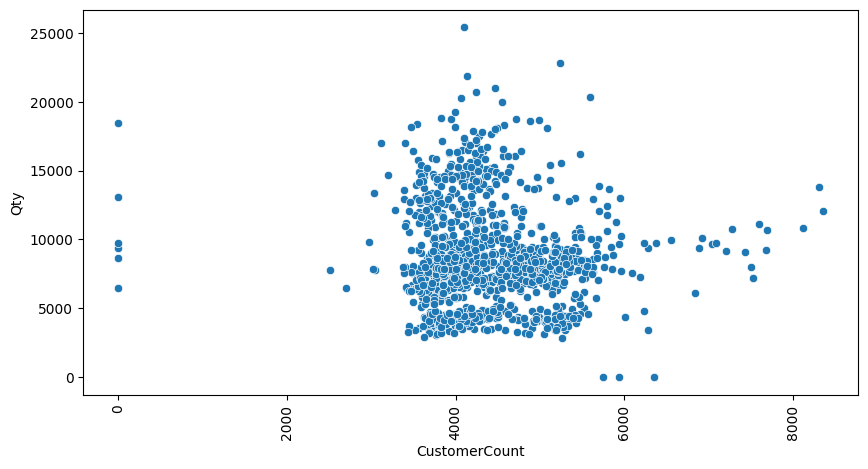

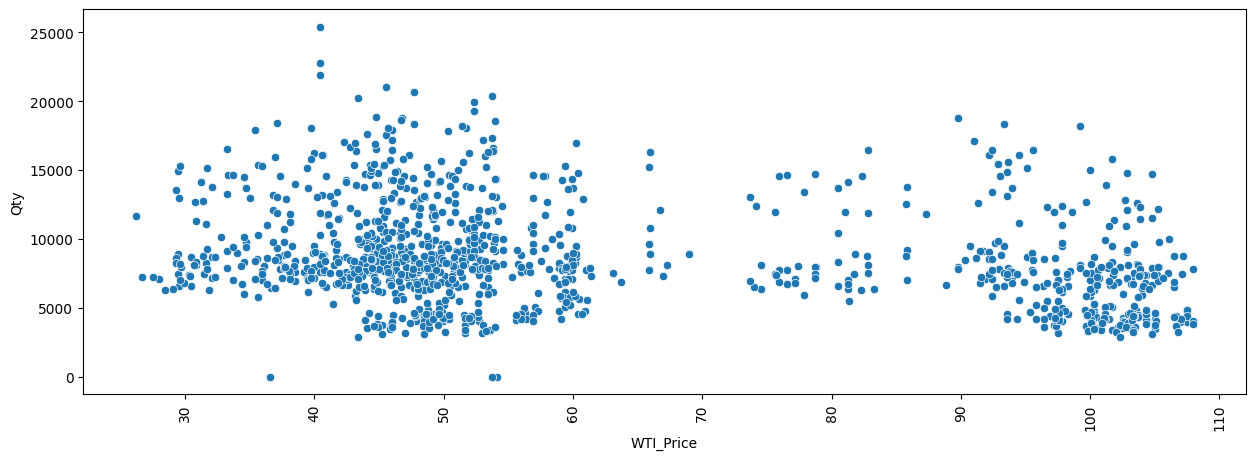

In [ ]:
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=beverage, x='Date', y='Qty')
# plt.xticks(rotation=90)
# plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=beverage, x='CustomerCount', y='Qty')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15, 5))
sns.scatterplot(data=beverage, x='WTI_Price', y='Qty')
plt.xticks(rotation=90)
plt.show()


## **(2) 상품 : 12 - Milk**

## **(3) 상품 : 42 - Agricultural products**

# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [ ]:
beverage.head()

,Qty,Price,WTI_Price,CustomerCount,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Open,High,Low,Close,Adj Close,Volume
0,8647.0,8,95.14,0.0,0,0,0,0,0,0,...,0,0,0,1,19.940001,19.9680,19.701000,19.898500,19.898500,42756000.0
1,15153.0,8,95.14,4422.0,0,0,0,0,0,0,...,0,1,0,0,19.940001,19.9680,19.701000,19.898500,19.898500,42756000.0
2,15606.0,8,93.66,4167.0,0,0,0,0,0,0,...,0,0,0,0,19.914499,20.1355,19.811001,19.822001,19.822001,44204000.0
3,7900.0,8,93.66,5341.0,0,0,0,0,0,0,...,0,0,0,0,19.914499,20.1355,19.811001,19.822001,19.822001,44204000.0
4,7188.0,8,93.66,5123.0,0,0,0,0,0,0,...,1,0,0,0,19.914499,20.1355,19.811001,19.822001,19.822001,44204000.0


In [ ]:
from sklearn.model_selection import train_test_split

target = 'Qty'
x = beverage.drop(target, axis=1)
y = beverage[target]
val_size = 60
x_train, y_train = x[:-val_size], y[:-val_size]
x_val = x[-val_size:]
y_val = y[-val_size:].values
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1092, 26), (1092,), (60, 26), (60,))

In [ ]:
x_train

,Price,WTI_Price,CustomerCount,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,...,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Open,High,Low,Close,Adj Close,Volume
0,8,95.14,0.0,0,0,0,0,0,0,0,...,0,0,0,1,19.940001,19.968000,19.701000,19.898500,19.898500,42756000.0
1,8,95.14,4422.0,0,0,0,0,0,0,0,...,0,1,0,0,19.940001,19.968000,19.701000,19.898500,19.898500,42756000.0
2,8,93.66,4167.0,0,0,0,0,0,0,0,...,0,0,0,0,19.914499,20.135500,19.811001,19.822001,19.822001,44204000.0
3,8,93.66,5341.0,0,0,0,0,0,0,0,...,0,0,0,0,19.914499,20.135500,19.811001,19.822001,19.822001,44204000.0
4,8,93.66,5123.0,0,0,0,0,0,0,0,...,1,0,0,0,19.914499,20.135500,19.811001,19.822001,19.822001,44204000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,8,52.01,5665.0,0,0,0,0,0,0,0,...,0,0,0,0,38.227501,38.325001,37.899502,38.029499,38.029499,39632000.0
1088,8,52.82,4675.0,0,0,0,0,0,0,0,...,0,0,1,0,38.169998,38.732498,38.060001,38.570000,38.570000,52774000.0
1089,8,54.01,5196.0,0,0,0,0,0,0,0,...,0,0,0,1,38.812500,39.000000,38.525002,38.606499,38.606499,66020000.0
1090,8,53.80,4802.0,0,0,0,0,0,0,0,...,0,1,0,0,38.619999,38.669998,38.042500,38.257500,38.257500,63166000.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

scaler_y = MinMaxScaler()
y_train_s = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_s = scaler_y.transform(np.array(y_val).reshape(-1, 1))

In [ ]:
y_train_s.shape, y_val_s.shape

((1092, 1), (60, 1))

### **2) 모델링**

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor(max_depth=5, random_state=42)
randomForest.fit(x_train_s, y_train_s)

RandomForestRegressor(max_depth=5, random_state=42)

In [ ]:
from sklearn.metrics import *

y_pred_rf = randomForest.predict(x_val_s)
y_pred_rf = scaler_y.inverse_transform(y_pred_rf.reshape(-1, 1))
# y_pred_rf
result = {}
result['Random Forest'] = {'RMSE': mean_squared_error(y_val, y_pred_rf) ** 0.5,
                           'MAE': mean_absolute_error(y_val, y_pred_rf),
                           'MAPE' : mean_absolute_percentage_error(y_val, y_pred_rf),
                           'R2_Score': r2_score(y_val, y_pred_rf)}
result

{'Random Forest': {'RMSE': 3632.884170312085,
  'MAE': 2452.750508864893,
  'MAPE': 0.18769833742986058,
  'R2_Score': 0.05318584131049642}}

In [ ]:
from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression()
linearRegression.fit(x_train_s, y_train)
y_pred_lr = randomForest.predict(x_val_s)
y_pred_lr = scaler_y.inverse_transform(np.array(pred_lr).reshape(-1, 1))
y_pred_lr = y_pred_rf.reshape(-1,)

result['Linear Regression'] = {'RMSE': mean_squared_error(y_val, y_pred_lr) ** 0.5,
                           'MAE': mean_absolute_error(y_val, y_pred_lr),
                           'MAPE' : mean_absolute_percentage_error(y_val, y_pred_lr),
                           'R2_Score': r2_score(y_val, y_pred_lr)}
result

{'Random Forest': {'RMSE': 3632.884170312085,
  'MAE': 2452.750508864893,
  'MAPE': 0.18769833742986058,
  'R2_Score': 0.05318584131049642},
 'Linear Regression': {'RMSE': 3632.884170312085,
  'MAE': 2452.750508864893,
  'MAPE': 0.18769833742986058,
  'R2_Score': 0.05318584131049642}}

## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

### **2) 모델링**

## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

### **2) 모델링**

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
# 3차원 구조로 변경
timesteps = 24
x2, y2 = temporalize(x, y, timesteps)

val_size = 60
x2_train, y2_train = x2[:-val_size], y2[:-val_size]
x2_val = x2[-val_size:]
y2_val = y2[-val_size:]
x2_train.shape, y2_train.shape, x2_val.shape, y2_val.shape

((1069, 24, 26), (1069,), (60, 24, 26), (60,))

In [ ]:
# 2차원으로 변환해서 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x2_train))

# 3차원 데이터에 스케일러 적용
x2_train_s = scale(x2_train, scaler)
x2_val_s = scale(x2_val, scaler)

# y에 대한 스케일링 (최적화를 위해)
scaler_y = MinMaxScaler()
y2_train_s = scaler_y.fit_transform(y2_train.reshape(-1, 1))
y2_val_s = scaler_y.transform(y2_val.reshape(-1, 1))

* **모델링**

In [ ]:
n_features = x2_train_s.shape[2]
timesteps = 24

clear_session()
m_LSTM = Sequential([LSTM(32, input_shape = (timesteps, n_features)),
                     Dense(16, activation='relu'),
                    Dense(1)])

m_LSTM.compile(optimizer = Adam(learning_rate = 0.01), loss='mse')

In [ ]:
x2_train_s.shape, y2_train_s.shape

((1069, 24, 26), (1069, 1))

In [ ]:
hist = m_LSTM.fit(x2_train_s, y2_train_s, epochs=30, validation_data=(x2_val_s, y2_val_s)).history

Epoch 1/30
34/34 [==============================] - 4s 39ms/step - loss: 0.0203 - val_loss: 0.0268
Epoch 2/30
34/34 [==============================] - 1s 16ms/step - loss: 0.0079 - val_loss: 0.0119
Epoch 3/30
34/34 [==============================] - 1s 18ms/step - loss: 0.0068 - val_loss: 0.0147
Epoch 4/30
34/34 [==============================] - 1s 16ms/step - loss: 0.0055 - val_loss: 0.0165
Epoch 5/30
34/34 [==============================] - 0s 13ms/step - loss: 0.0049 - val_loss: 0.0150
Epoch 6/30
34/34 [==============================] - 0s 11ms/step - loss: 0.0048 - val_loss: 0.0099
Epoch 7/30
34/34 [==============================] - 0s 11ms/step - loss: 0.0050 - val_loss: 0.0196
Epoch 8/30
34/34 [==============================] - 0s 11ms/step - loss: 0.0048 - val_loss: 0.0124
Epoch 9/30
34/34 [==============================] - 0s 11ms/step - loss: 0.0045 - val_loss: 0.0144
Epoch 10/30
34/34 [==============================] - 0s 12ms/step - loss: 0.0044 - val_loss: 0.0144
Epoch 11/

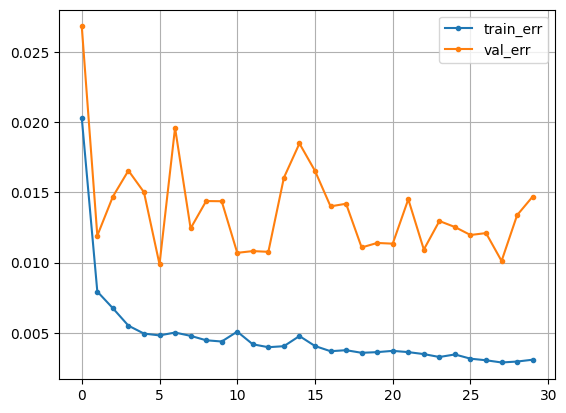

In [ ]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [ ]:
pred = m_LSTM.predict(x2_val_s)
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1, )

result['LSTM'] = {'RMSE': mean_squared_error(y2_val, pred) ** 0.5,
                           'MAE': mean_absolute_error(y2_val, pred),
                           'MAPE' : mean_absolute_percentage_error(y2_val, pred),
                           'R2_Score': r2_score(y2_val, pred)}
result

2/2 [==============================] - 0s 8ms/step


{'Random Forest': {'RMSE': 3632.884170312085,
  'MAE': 2452.750508864893,
  'MAPE': 0.18769833742986058,
  'R2_Score': 0.05318584131049642},
 'Linear Regression': {'RMSE': 3632.884170312085,
  'MAE': 2452.750508864893,
  'MAPE': 0.18769833742986058,
  'R2_Score': 0.05318584131049642},
 'LSTM': {'RMSE': 3080.6418049705753,
  'MAE': 2285.5514404296873,
  'MAPE': 0.18410446763333252,
  'R2_Score': 0.31916158722428556}}

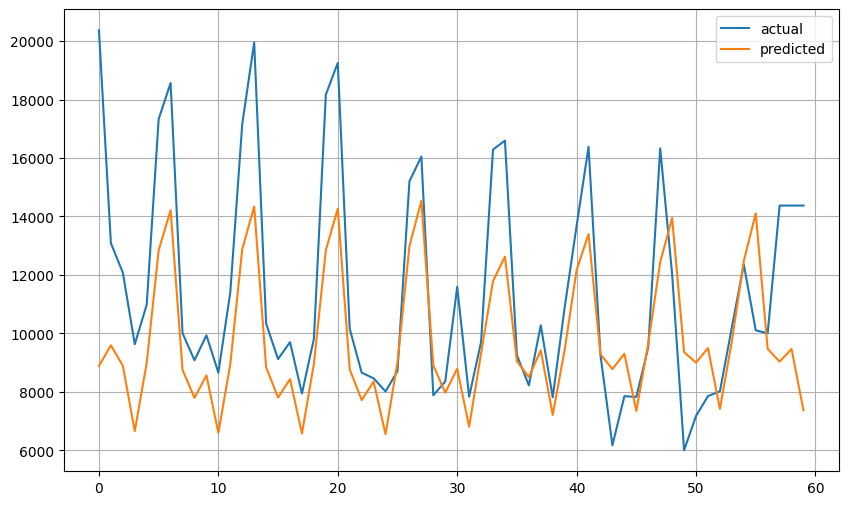

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(y2_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
n_features = x2_train_s.shape[2]
timesteps = 24

clear_session()

CNN = Sequential([Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                  Dense(16, activation='relu'),
                    Flatten(),
                    Dense(1)])

CNN.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mse')

In [ ]:
hist = CNN.fit(x2_train_s, y2_train_s, epochs=30, validation_data = (x2_val_s, y2_val_s)).history

Epoch 1/30
34/34 [==============================] - 1s 8ms/step - loss: 0.0599 - val_loss: 0.0181
Epoch 2/30
34/34 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0191
Epoch 3/30
34/34 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0165
Epoch 4/30
34/34 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0214
Epoch 5/30
34/34 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0191
Epoch 6/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0255
Epoch 7/30
34/34 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0173
Epoch 8/30
34/34 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0215
Epoch 9/30
34/34 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0143
Epoch 10/30
34/34 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0173
Epoch 11/30
34/34 [

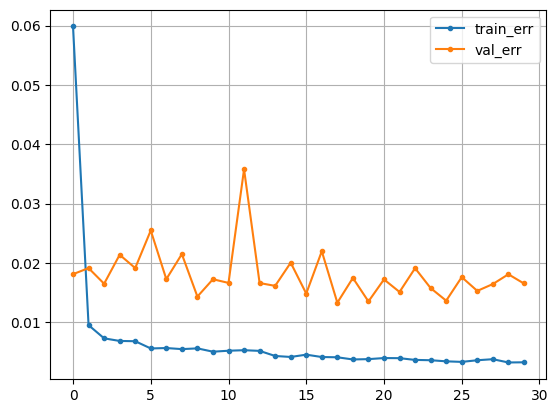

In [ ]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* **모델링**

In [ ]:
pred = CNN.predict(x2_val_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

result['CNN'] = {'RMSE': mean_squared_error(y2_val, pred) ** 0.5,
                           'MAE': mean_absolute_error(y2_val, pred),
                           'MAPE' : mean_absolute_percentage_error(y2_val, pred),
                           'R2_Score': r2_score(y2_val, pred)}
result

2/2 [==============================] - 0s 5ms/step


{'Random Forest': {'RMSE': 3632.884170312085,
  'MAE': 2452.750508864893,
  'MAPE': 0.18769833742986058,
  'R2_Score': 0.05318584131049642},
 'Linear Regression': {'RMSE': 3632.884170312085,
  'MAE': 2452.750508864893,
  'MAPE': 0.18769833742986058,
  'R2_Score': 0.05318584131049642},
 'LSTM': {'RMSE': 3080.6418049705753,
  'MAE': 2285.5514404296873,
  'MAPE': 0.18410446763333252,
  'R2_Score': 0.31916158722428556},
 'CNN': {'RMSE': 3268.6531801788224,
  'MAE': 2349.407120768229,
  'MAPE': 0.18567350835080002,
  'R2_Score': 0.23352264939893996}}

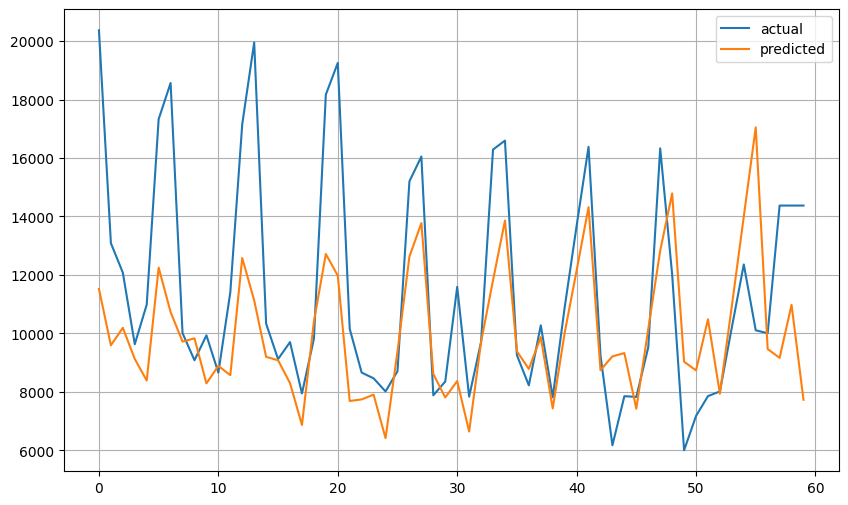

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(y2_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
result

{'Random Forest': {'RMSE': 3632.884170312085,
  'MAE': 2452.750508864893,
  'MAPE': 0.18769833742986058,
  'R2_Score': 0.05318584131049642},
 'Linear Regression': {'RMSE': 3632.884170312085,
  'MAE': 2452.750508864893,
  'MAPE': 0.18769833742986058,
  'R2_Score': 0.05318584131049642},
 'LSTM': {'RMSE': 3080.6418049705753,
  'MAE': 2285.5514404296873,
  'MAPE': 0.18410446763333252,
  'R2_Score': 0.31916158722428556},
 'CNN': {'RMSE': 3268.6531801788224,
  'MAE': 2349.407120768229,
  'MAPE': 0.18567350835080002,
  'R2_Score': 0.23352264939893996}}